In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from ipywidgets import AppLayout, IntSlider
%matplotlib widget

ModuleNotFoundError: No module named 'ipywidgets'

## Exponential Moving Average /w scheduled momentum
### Toy setting which is close to MNIST witch batchsize 256

In [2]:
DATA_SIZE = 40000
BATCH_SIZE = 200
IT_PER_EPOCH = DATA_SIZE // BATCH_SIZE
EPOCHS = 50

EPOCHS, IT_PER_EPOCH, EPOCHS*IT_PER_EPOCH

(50, 200, 10000)

### Choice of Momentum Scheduler

(10000,)

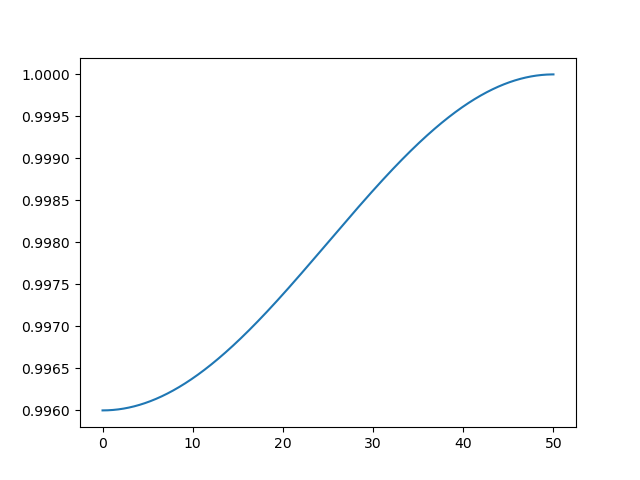

In [13]:
class _Sched():
    def __init__(self, min, max, it_per_epoch, epochs):
        self.min = min
        self.max = max
        self.it_per_epoch = it_per_epoch
        self.epochs = epochs

        # compoute iterations
        self.its = np.linspace(0, epochs, epochs * it_per_epoch)
        self.ys = self.xs()
    
    def xs(self, lower=0, upper=1):
        return lower + (upper-lower) * self.its/self.its.max()
        
    def __call__(self, it, epoch_offset=0):
        'If offset = 0, indexes absolute iteration'
        return self.ys[it + epoch_offset * self.it_per_epoch]


class ConstSched(_Sched):
    def __init__(self, val, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)
        self.ys.fill(val)


class LinSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)

        self.ys = min + (max-min) * self.xs()

class CosSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs): 
        super().__init__(min, max, it_per_epoch, epochs)

        self.cos = 0.5 + np.cos(self.xs(-np.pi,0)) / 2
        self.ys = min + (max-min) * self.cos


plt.ion()
plt.figure()

#tmom = ConstSched(0.9998, IT_PER_EPOCH, EPOCHS)
tmom = CosSched(0.996, 1.0, IT_PER_EPOCH, EPOCHS)
plt.plot(tmom.its, tmom.ys)
tmom.its.shape

### Contribution of past students on teacher during training

In [14]:
def distribution(tmom, t):
    c = np.zeros_like(tmom.its)
    c[0] = 1
    for i in range(1, t):
        c[i] = 1 - tmom(i)
        c[:i] *= tmom(i)
    return c

In [15]:
def plot_distribution(tmom, n_ticks, zoomed_ylim):
    # Widget should handly interactive 
    plt.ioff()
    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8, 4))

    # Slider
    slider = IntSlider(
        orientation='horizontal',
        description='Iteration:',
        value=1,
        min=1,
        max=len(tmom.its)-1,
    )
    slider.layout.margin = '0px 30% 0px 30%'
    slider.layout.width = '40%'

    # Data
    pdf = distribution(tmom, 1)
    cdf = pdf[::-1].cumsum()[::-1]

    # Default axis
    cdf_l, = ax[0].plot(tmom.its, cdf, c='C1', label='cdf')
    pdf_l, = ax[0].plot(tmom.its, pdf, c='C0', label='pdf')
    ax[0].set_xticks(np.linspace(0, EPOCHS, n_ticks))
    
    # Zoomed axis
    #cdf_r, = ax[1].plot(tmom.its, cdf, c='C1', label='cdf')
    #ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[1] = ax[1].twinx()
    pdf_r, = ax[1].plot(tmom.its, pdf, c='C0', label='pdf')
    ax[1].set_ylim(zoomed_ylim)
    ax[1].yaxis.tick_right()

    plt.suptitle('Distribution of EMA at iteration t')
    ax[0].legend()


    def update(change):
        pdf = distribution(tmom, change.new)
        cdf = pdf[::-1].cumsum()[::-1]

        cdf_l.set_ydata(cdf)
        pdf_l.set_ydata(pdf)
        #cdf_r.set_ydata(cdf)
        pdf_r.set_ydata(pdf)

        fig.canvas.draw()
        fig.canvas.flush_events()


    slider.observe(update, names='value')
    return AppLayout(
        center=fig.canvas,
        footer=slider,
        pane_heights=[0, 6, 1]
    )


plot_distribution(tmom, EPOCHS//5 + 1, (-0.0002, 0.0042))

AppLayout(children=(IntSlider(value=1, description='Iteration:', layout=Layout(grid_area='footer', margin='0px…

### When is the contribution of the initial student negligible?

Before iteration

0. Student is initiallized at some location $v_0$
1. Student $v_1$ after sgd step, teacher $w_1 = v_1*0.004 + v_0*0.996$
2. Student $v_2$ after sgd step, teacher $w_2 = v_2*0.004 + (v_0*0.004 + w_0*0.996)*0.996$

At iteration t:
- Teacher: $w_t = v_t*0.004 + ... + (v_1*0.004 + v_0 * 0.996)*0.996^{t-1}$
- The contribution of $v_0$ is $0.996 * 0.996^{t-1}$, compared to $0.004 * 0.996^{t-1}$ for $v_1$

At iteration $t=log(0.004)/log(0.996)$~$1338$ or 6.9 epochs:
- The contribution of $v_0$ is $0.996^t=0.004$ which is comparable to $v_1$ at the very beginning<br>
  $0.996^t=0.004 <=> log(0.996^t)=log(0.004) <=> tlog(0.996)=log(0.004)$
- This also means that all other students $v_1, v_2, ..$ together account for 0.996 of the current teacher.
- It takes another 6.9 epochs for $v_0$ to be as negligible as $v_1$ after 6.9 epochs.

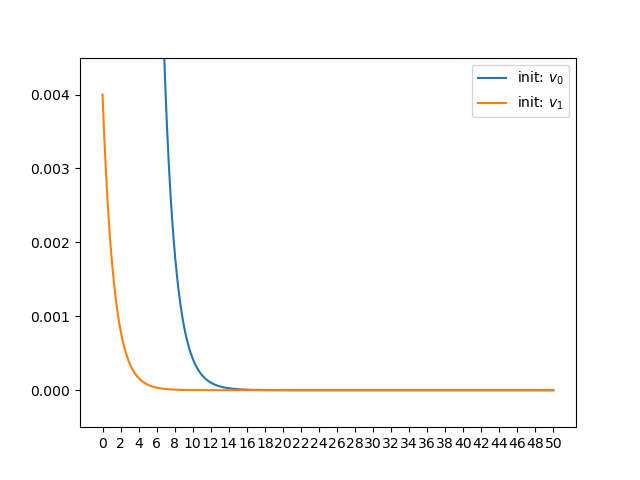

In [16]:
plt.ion()
plt.figure()

def contrib_vt(tmom, t=0):
    c = np.full_like(tmom.its, np.nan)
    c[0] =  tmom(0) if t==0 else (1-tmom(0))*tmom(0)**(t-1)
    for i in range(1, len(tmom.its)):
        c[i] = c[i-1] * tmom(i)
    return c


plt.plot(tmom.its, contrib_vt(tmom, 0), label=f'init: $v_0$')
plt.plot(tmom.its, contrib_vt(tmom, 1), label=f'init: $v_1$')
plt.xticks(np.linspace(0, EPOCHS, EPOCHS//2 + 1))
#plt.yscale('log')
plt.ylim(-0.0005, 0.0045)
plt.legend()

### Can we change the behavoir with a different Scheduler?

(10000,)

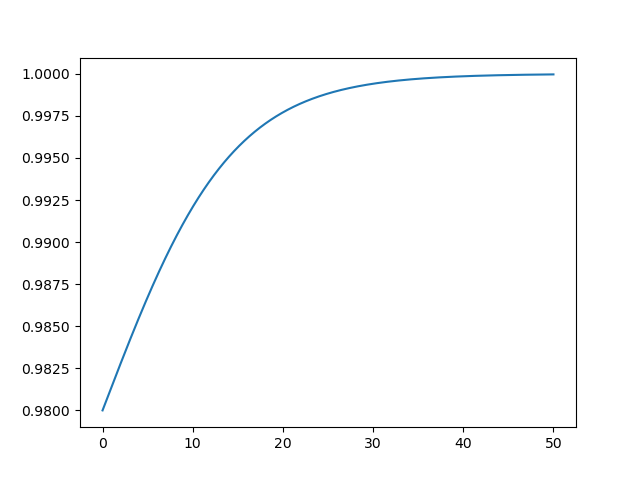

In [17]:
class CosCyclSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)

        self.cos = 0.5 + np.cos(self.xs*2*np.pi) / 2    
        self.ys = min + (max-min) * self.cos

class SigmoidSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)
        
        self.sigmoid = expit(self.xs(-4, 4)) 
        self.ys = min + (max-min) * self.sigmoid

class HalfSigmoidSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)
        
        self.sigmoid = expit(self.xs(0,7)) * 2 - 1
        self.ys = min + (max-min) * self.sigmoid

class HalfCosSched(_Sched):
    def __init__(self, min, max, it_per_epoch, epochs):
        super().__init__(min, max, it_per_epoch, epochs)

        self.cos = np.cos(self.xs(-np.pi/2, 0))
        self.ys = min + (max-min) * self.cos



plt.ion()
plt.figure()


tmom = HalfSigmoidSched(0.98, 1.0, IT_PER_EPOCH, EPOCHS)
plt.plot(tmom.its, tmom.ys)
tmom.its.shape

In [18]:
plot_distribution(tmom, EPOCHS//5 + 1, (-0.0005, 0.01))

AppLayout(children=(IntSlider(value=1, description='Iteration:', layout=Layout(grid_area='footer', margin='0px…

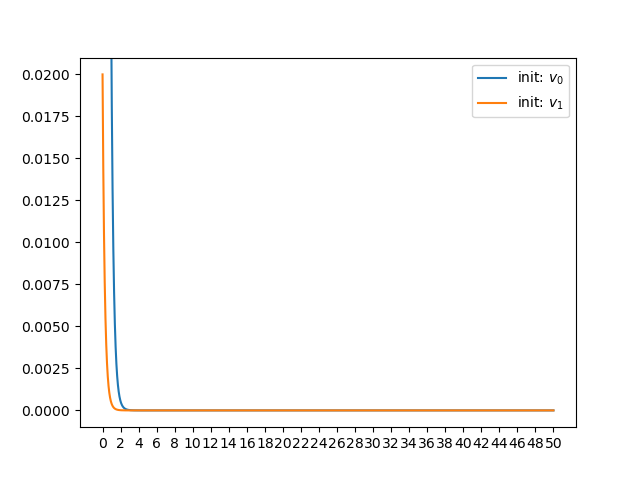

In [19]:
plt.ion()
plt.figure()

plt.plot(tmom.its, contrib_vt(tmom, 0), label=f'init: $v_0$')
plt.plot(tmom.its, contrib_vt(tmom, 1), label=f'init: $v_1$')
plt.xticks(np.linspace(0, EPOCHS, EPOCHS//2 + 1))
#plt.yscale('log')
plt.ylim(-0.001, 0.021)
plt.legend()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LinWarmup(0.1, 0.6, 10)


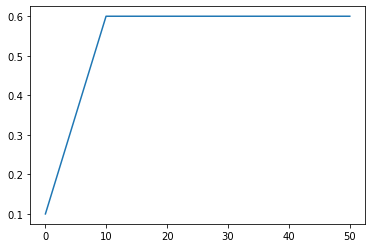

In [19]:
%load_ext autoreload
%autoreload 2
from scheduling import Schedule, ConstSched, LinSched, CosSched, CatSched
import matplotlib.pyplot as plt
EPOCHS = 50
N_STEPS = 1000

#sched = CatSched(0.4, 0.6)
sched = Schedule.parse('LinWarmup(0.1, 0.6, 10)')

print(sched.prep(N_STEPS, EPOCHS))
plt.plot(sched.xs(0, EPOCHS), sched.ys)